In [1]:
import iris
import matplotlib.pyplot as plt
import numpy as np
from aeolus.const import init_const
from aeolus.meta import const_from_attrs, update_metadata
from aeolus.plot import figsave

In [2]:
from common import GROUPS, PROJECT, SIMULATIONS, pres_label_to_value
import paths

In [3]:
SIM_GROUP = "pres"

const = init_const("trap1e")

In [4]:
@const_from_attrs()
@update_metadata("saturation_vapour_pressure", units="Pa")
def saturation_vapour_pressure(temp, const=None):
    water_trp_temp = iris.cube.Cube(273.16, units="K")
    sat_vap_pres_at_water_trp = iris.cube.Cube(611.2, units="Pa")
    water_gas_const = const.molar_gas_constant / const.water_molecular_weight
    exp_term = iris.analysis.maths.exp(
        const.condensible_heat_vaporization
        / water_gas_const
        * (1 / water_trp_temp - 1 / temp)
    )
    return sat_vap_pres_at_water_trp * exp_term


@const_from_attrs()
@update_metadata("saturation_vapour_mixing_ratio", units="kg kg-1")
def saturation_vapour_mixing_ratio(pres, temp, const=None):
    eps = const.water_molecular_weight / const.dry_air_molecular_weight
    sat_vap_pres = saturation_vapour_pressure(temp, const=const)
    return eps * sat_vap_pres / (pres - sat_vap_pres)


@const_from_attrs()
@update_metadata("moist_adiabatic_lapse_rate", units="K km-1")
def moist_adiabatic_lapse_rate(pres, temp, const=None):
    d_term = const.gravity / const.dry_air_spec_heat_press
    eps = const.water_molecular_weight / const.dry_air_molecular_weight
    sat_mr = saturation_vapour_mixing_ratio(pres, temp, const=const)
    m_term_1 = 1.0 + const.condensible_heat_vaporization * sat_mr / (
        const.dry_air_gas_constant * temp
    )
    m_term_2 = 1.0 + eps * const.condensible_heat_vaporization**2 * sat_mr / (
        const.dry_air_spec_heat_press * const.dry_air_gas_constant * temp**2
    )
    return d_term * m_term_1 / m_term_2

In [5]:
temp_data = [250, 270, 290]
pres_data = np.arange(0, 15, 0.1)
temp_data_mesh, pres_data_mesh = np.meshgrid(temp_data, pres_data)

temperature = iris.cube.Cube(temp_data_mesh, units="K")
pressure = iris.cube.Cube(pres_data_mesh, units="bar")
pressure.convert_units("Pa")

lapse_rates = moist_adiabatic_lapse_rate(pressure, temperature, const=const)

Saved to ../figures/drafts/thunderstruck__pres__moist_lapse_rate__for_250K_270K_290K.pdf
Size: 19.5 KB


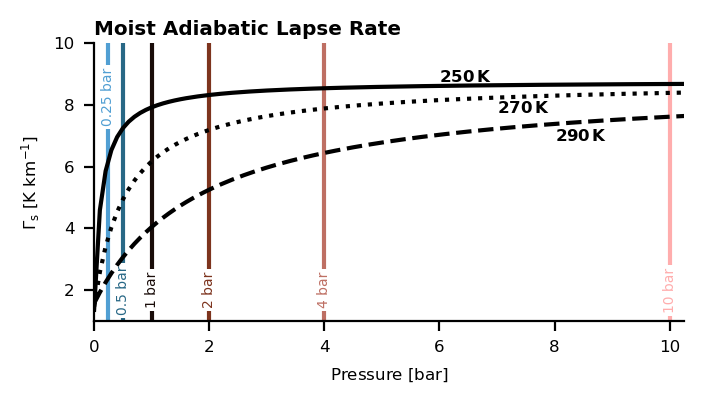

In [6]:
savefig = True
kw_temp = {
    250: {"kw_plt": {"linestyle": "solid", "color": "black"}, "label_xy": (6, 8.75)},
    270: {"kw_plt": {"linestyle": "dotted", "color": "black"}, "label_xy": (7, 7.75)},
    290: {"kw_plt": {"linestyle": "dashed", "color": "black"}, "label_xy": (8, 6.85)},
}
fig, ax = plt.subplots(figsize=(3.5, 2), layout="tight")
ax.set_title("Moist Adiabatic Lapse Rate", loc="left", y=1.0)
ax.set_xlim(0, 10.25)
ax.set_xlabel(
    "Pressure [$bar$]",
    size="medium",
)
ax.set_ylim(1, 10)
ax.set_ylabel(
    "$\Gamma_s$ [$K$ $km^{-1}$]",
    size="medium",
)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
for sim in GROUPS[SIM_GROUP].simulations:
    ax.axvline(pres_label_to_value(sim), color=SIMULATIONS[sim].kw_plt["color"])

for sim in GROUPS[SIM_GROUP].simulations:
    ax.text(
        pres_label_to_value(sim),
        2 if sim != "hab1_0p25bar" else 8.25,
        SIMULATIONS[sim].title,
        rotation=90,
        fontsize="small",
        va="center",
        ha="center",
        color=SIMULATIONS[sim].kw_plt["color"],
        bbox=dict(boxstyle="square,pad=0.2", fc="white", ec="none"),
    )

for itemp, _temp in enumerate(temp_data):
    ax.plot(
        pres_data,
        lapse_rates.data[:, itemp],
        label=_temp,
        **kw_temp[_temp]["kw_plt"],
        zorder=100,
    )
    ax.text(*kw_temp[_temp]["label_xy"], f"${_temp}\,K$", size="medium", weight="bold")

# axx = ax.twiny()
# axx.tick_params(
#     axis="x", which="major", pad=5, labelbottom=False, labeltop=True, length=0
# )
# axx.set_xticks([pres_label_to_value(i) for i in GROUPS[SIM_GROUP].simulations])
# axx.set_xticklabels(
#     [SIMULATIONS[sim].title for sim in GROUPS[SIM_GROUP].simulations],
#     size="large",
#     rotation=60,
# )
# for xtick, sim in zip(axx.get_xticklabels(), GROUPS[SIM_GROUP].simulations):
#     xtick.set_color(SIMULATIONS[sim].kw_plt["color"])
# axx.spines.right.set_visible(False)
# axx.spines.top.set_visible(False)
if savefig:
    figsave(
        fig,
        paths.figures
        / "drafts"
        / f"{PROJECT}__{SIM_GROUP}__moist_lapse_rate__for_{'_'.join([f'{i:.0f}K' for i in temp_data])}",
    )